In [1]:
# IMPORT
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path

# bokeh
import bokeh.palettes
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Legend, ColumnDataSource, Title
from bokeh.tile_providers import get_provider, CARTODBPOSITRON
from bokeh.models import GeoJSONDataSource

output_notebook()

Loading BokehJS ...

# Data Preprocessing

**Clean and export `air_quality_data.csv`**

**Clean and export `air_quality_stations.csv`**

# Visualisations

Load and join tables

In [2]:
# load air quality stations
df_stations = pd.read_csv('shared_data/air_quality/air_quality_stations.csv')
# load magnitud table
df_magnitud = pd.read_csv('shared_data/air_quality/air_quality_magnitud.csv', sep=';')
# load air quality data
df = pd.read_csv('data/air_quality_data.csv')
# converting Date to datetime type
df["datetime"] = pd.to_datetime(df["datetime"])
# merge with air quality stations
df = pd.merge(df, df_stations, left_on = 'PUNTO_MUESTREO', right_on='punto_muestreo', how='left').drop('PUNTO_MUESTREO', axis=1)
# merge with air quality magnitud
df = pd.merge(df, df_magnitud, left_on = 'MAGNITUD', right_on='magnitud_id', how='left').drop('MAGNITUD', axis=1)
df.head()

,PROVINCIA,MUNICIPIO,ESTACION,value,datetime,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,magnitud_id,formula,unit_per_m3
0,28,79,4,7.0,2016-04-01 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg
1,28,79,4,8.0,2016-04-02 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg
2,28,79,4,10.0,2016-04-03 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg
3,28,79,4,7.0,2016-04-04 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg
4,28,79,4,8.0,2016-04-05 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,1,SO2,µg


Get the names of air quality stations:

In [3]:
print('AIR QUALITY STATION NAMES:')
df.name.unique()

AIR QUALITY STATION NAMES:


array(['Plaza de España', 'Escuelas Aguirre', 'Ramón y Cajal',
       'Arturo Soria', 'Villaverde', 'Farolillo', 'Casa de Campo',
       'Barajas Pueblo', 'Plaza del Carmen', 'Moratalaz',
       'Cuatro Caminos', 'Barrio del Pilar', 'Vallecas', 'Méndez Álvaro',
       'Castellana', 'Retiro', 'Plaza Castilla', 'Ensanche de Vallecas',
       'Urbanización Embajada', 'Plaza Elíptica', 'Sanchinarro',
       'El Pardo', 'Juan Carlos I', 'Tres Olivos'], dtype=object)

Choose a location (station `name`) and a gas to track (`MAGNITUD` id):

In [6]:
aLocation = 'Plaza de España'
aFormula = 'NO2'

df_focus = df[(df.name == aLocation) & (df.formula==aFormula)]
df_focus.sort_values('datetime')

,PROVINCIA,MUNICIPIO,ESTACION,value,datetime,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,magnitud_id,formula,unit_per_m3
1944765,28,79,4,57.0,2016-01-01 01:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1949446,28,79,4,55.0,2016-01-01 02:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1954127,28,79,4,57.0,2016-01-01 03:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1958808,28,79,4,54.0,2016-01-01 04:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
1963489,28,79,4,51.0,2016-01-01 05:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7103229,28,79,4,0.0,2021-10-25 20:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
7107291,28,79,4,0.0,2021-10-25 21:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
7111353,28,79,4,0.0,2021-10-25 22:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg
7115415,28,79,4,0.0,2021-10-25 23:00:00,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,8,NO2,µg


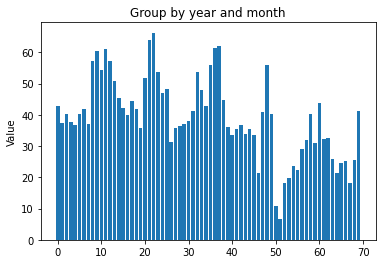

In [7]:
# plot bars
heights = df_focus.groupby([df_focus.datetime.dt.year, df_focus.datetime.dt.month]).mean().value.values
plt.bar(range(len(heights)), heights)
plt.title('Group by year and month')
plt.ylabel('Value')
plt.show()

### Air Quality Stations (map)

In [8]:
# load MC area
cm_points = pd.read_csv('shared_data/districts/central_madrid_points.csv')

# red = outside MC, blue = inside MC

points = df_stations[["utm_x", "utm_y"]].values
path = Path(cm_points[["utm_x", "utm_y"]].values)
points_in_path_mask = path.contains_points(points)

df_stations["color"] = "red"

df_stations.loc[points_in_path_mask, "color"] = "blue"
df_stations.head()

,punto_muestreo,name,longitude,latitude,altitude,utm_x,utm_y,color
0,28079035,Plaza del Carmen,-3.703167,40.419208,660,-412234.627656,4.927049e+06,blue
1,28079004,Plaza de España,-3.712197,40.423883,637,-413239.904502,4.927732e+06,red
2,28079039,Barrio del Pilar,-3.711536,40.478233,676,-413166.309950,4.935683e+06,red
3,28079008,Escuelas Aguirre,-3.682283,40.421564,672,-409909.905623,4.927393e+06,red
4,28079038,Cuatro Caminos,-3.707122,40.445547,699,-412674.958086,4.930901e+06,red


In [38]:
# plot map
p = figure(title="Air quality stations in Madrid", x_axis_type="mercator", y_axis_type="mercator")

source = ColumnDataSource(df_stations)
cr = p.circle(x="utm_x", y="utm_y",  size=10, color="color", source=source)

cartodb = get_provider(CARTODBPOSITRON)
p.add_tile(cartodb)

p.add_tools(HoverTool(tooltips=[('Name', '@name')], renderers=[cr]))

show(p)

### Compare two districts

In [11]:
# select districts and gas to track
aLocation = 'Plaza de España'
aLocation2 = 'Plaza del Carmen'
aFormula = 'NO2'

# filtering
df_focus2 = df[(df.name.isin([aLocation, aLocation2])) & (df.formula==aFormula)]
# get values comparison per year
df_focus2.groupby([df_focus2.name, df_focus2.datetime.dt.year]).describe()['value']

count       mean        std   min   25%   50%  \
name             datetime                                                   
Plaza de España  2016      8783.0  45.645907  28.450476   0.0  25.0  40.0   
                 2017      8760.0  49.411301  30.644147   0.0  27.0  43.0   
                 2018      8760.0  42.955023  26.700519   0.0  23.0  38.0   
                 2019      8736.0  39.528159  27.182600   0.0  20.0  33.0   
                 2020      7104.0  30.214527  27.181571   0.0  11.0  24.0   
                 2021      6769.0  28.163392  27.843819   0.0  11.0  21.0   
Plaza del Carmen 2016      8471.0  45.721520  23.205295   0.0  28.0  42.0   
                 2017      8760.0  49.088470  23.108229   0.0  31.0  45.0   
                 2018      8616.0  44.132892  21.332328   0.0  28.0  41.0   
                 2019      8712.0  35.901515  23.361379   0.0  18.0  30.0   
                 2020      8784.0  29.520947  22.097664   0.0  13.0  22.0   
                 2021      8760.0  31.356963  22.012821   0.0  15.0  25.0   
                 2022         1.0  55.000000        NaN  55.0  55.0  55.0   

                             75%     max  
name             datetime                 
Plaza de España  2016      61.00   250.0  
                 2017      66.00   283.0  
                 2018      57.00   226.0  
                 2019      53.00   210.0  
                 2020      43.25  1117.0  
                 2021      38.00  1162.0  
Plaza del Carmen 2016      59.00   194.0  
                 2017      63.00   188.0  
                 2018      57.00   261.0  
                 2019      49.00   185.0  
                 2020      41.00   148.0  
                 2021      43.00   209.0  
                 2022      55.00    55.0

## Visualisation 1: evolution of TRAP in Centro over time

*Compute the average and std of the value for each recorded gas.*

In [180]:
df1 = df[(df.name == 'Plaza del Carmen')][['formula','value','datetime']]
df1 = df1.pivot(index='datetime', columns='formula', values='value').reset_index()
df1['datetime'] = df1.datetime.dt.round('D')
df1['datetime'] = df1['datetime'] + pd.offsets.MonthBegin(0)

In [181]:
# get mean
df1_mean = df1.groupby(['datetime']).mean().reset_index()
df1_mean["datetime"] = pd.to_datetime(df1_mean["datetime"])
df1_mean = df1_mean.set_index('datetime')

In [182]:
def get_month_year(aRow):
    return aRow.name.month_name() + ' ' + str(aRow.name.year)

df1_mean['date'] = df1_mean.apply(get_month_year, axis=1)

In [183]:
df1_mean

formula,CO,NO,NO2,NOx,O3,SO2,date
datetime,,,,,,,
2016-01-01,0.409091,20.181818,49.000000,79.909091,12.931818,5.181818,January 2016
2016-02-01,0.413826,33.343624,46.096644,97.063087,23.471195,8.277852,February 2016
2016-03-01,0.373094,24.923741,42.732374,80.733813,23.210259,10.964029,March 2016
2016-04-01,0.347919,15.177181,45.410738,68.629530,32.291570,10.608054,April 2016
2016-05-01,0.294028,11.781944,41.305556,59.368056,40.624861,12.383333,May 2016
...,...,...,...,...,...,...,...
2021-09-01,0.228129,3.226110,22.519515,27.488560,74.582880,7.010767,September 2021
2021-10-01,0.276667,7.250000,29.358333,39.593056,52.918181,8.258333,October 2021
2021-11-01,0.326309,11.645638,39.773154,57.628188,50.358980,2.710067,November 2021


*Convert your `DataFrame` to Bokeh `ColumnDataSource`.*

In [184]:
cds_mean = ColumnDataSource(data=df1_mean)

In [185]:
df1_mean.columns

Index(['CO', 'NO', 'NO2', 'NOx', 'O3', 'SO2', 'date'], dtype='object', name='formula')

*Generate Bokeh figure*

In [186]:
p = figure(
    width=950, 
    height=400, 
    x_axis_type="datetime",
    title='Evolution of polluting gases over time in Centro, Madrid', 
    y_axis_label='gas concentration', 
    x_axis_label='date'
)

# create color palette
colors_gas = dict(zip(df1_mean.columns.values,list(bokeh.palettes.brewer['Dark2'][len(df1_mean.columns.values)])))

# add the data of each gas
lines, circles = {}, {}
for aGas in df1_mean.columns.values:
    # add line
    lines[aGas] = p.line('datetime', aGas, source=cds_mean, color = colors_gas[aGas])
    # add dots
    circles[aGas] = p.circle('datetime',aGas, source=cds_mean, color=colors_gas[aGas], size=5, alpha=0.3)
    p.add_tools(HoverTool(tooltips=[(aGas, '@'+aGas), ('date', '@date')], renderers=[circles[aGas]]))

# add interactive legend
items = [] 
for i in list(lines.keys())[:-1]:
    unit = df_magnitud[df_magnitud.formula==i].unit_per_m3.values[0]
    items.append((f'{i} ({unit}/m3)', [lines[i], circles[i]]))
legend = Legend(items=items, location='center') 
legend.click_policy="hide"
p.add_layout(legend, 'right')

show(p)

### Compare with the month of the previous year

In [196]:
# get mean
df2_mean = df1.groupby(['datetime']).mean().reset_index()
df2_mean["datetime"] = pd.to_datetime(df2_mean["datetime"])
df2_mean = df2_mean.set_index('datetime')
df2_mean["month"] = df2_mean.index.month
df2_mean["year"] = df2_mean.index.year

# get percentage
def get_progress_percent(aRow):
    previousRow = df2_mean[(df2_mean.month==aRow.month) & (df2_mean.year==aRow.year-1)]
    if len(previousRow) != 0:
        previousRow = previousRow.iloc[0]
        ratios = (aRow - previousRow)/previousRow
        datetime_to_keep = aRow.name
        ratios.name = datetime_to_keep
        ratios.month = datetime_to_keep.month
        ratios.year = datetime_to_keep.year
        return ratios
    return None
df2_ratios = df2_mean[df2_mean.year > 2016].apply(get_progress_percent, axis=1)

# get date display
df2_ratios['date'] = df2_ratios.apply(get_month_year, axis=1)

# drop SO2 (outlier)
df2_ratios = df2_ratios.drop('SO2',axis=1)

# bokeh
cds_ratios = ColumnDataSource(data=df2_ratios)

p = figure(
    width=950, 
    height=400, 
    x_axis_type="datetime",
    title='Evolution of polluting gases over time in Centro, Madrid', 
    y_axis_label='gas concentration', 
    x_axis_label='date'
)

# add the data of each gas
lines, circles = {}, {}
for aGas in df2_ratios.columns.values[:-3]:
    # add line
    lines[aGas] = p.line('datetime', aGas, source=cds_ratios, color = colors_gas[aGas])
    # add dots
    circles[aGas] = p.circle('datetime',aGas, source=cds_ratios, color=colors_gas[aGas], size=5, alpha=0.3)
    p.add_tools(HoverTool(tooltips=[(aGas, '@'+aGas), ('date', '@date')], renderers=[circles[aGas]]))

p.line()

# add interactive legend
items = [] 
for i in list(lines.keys()):
    unit = df_magnitud[df_magnitud.formula==i].unit_per_m3.values[0]
    items.append((f'{i} ({unit}/m3)', [lines[i], circles[i]]))
legend = Legend(items=items, location='center') 
legend.click_policy="hide"
p.add_layout(legend, 'right')

show(p)

In [175]:
df2_ratios

formula,CO,NO,NO2,NOx,O3,SO2,month,year,date
datetime,,,,,,,,,
2017-01-01,0.377056,2.563314,0.163644,1.092865,-0.207616,0.286400,1.0,2017.0,January 2017
2017-02-01,0.255271,0.590314,0.305166,0.457186,0.558917,0.091779,2.0,2017.0,February 2017
2017-03-01,0.077302,0.063243,0.152487,0.113595,0.282072,-0.651729,3.0,2017.0,March 2017
2017-04-01,0.143502,0.633287,0.023379,0.230670,0.276458,-0.676469,4.0,2017.0,April 2017
2017-05-01,0.038734,0.058470,0.016947,0.029290,0.378867,-0.787685,5.0,2017.0,May 2017
...,...,...,...,...,...,...,...,...,...
2021-09-01,-0.149368,-0.502597,-0.052091,-0.179265,0.077867,-0.081263,9.0,2021.0,September 2021
2021-10-01,-0.155574,-0.098446,-0.013994,-0.045535,-0.141967,-0.004354,10.0,2021.0,October 2021
2021-11-01,-0.165988,0.028737,0.254253,0.176894,0.191698,-0.243300,11.0,2021.0,November 2021


In [209]:
# vertical bars
p = figure(width=900, height=300, x_axis_type="datetime")

bar ={} # to store vbars 
# here we will do a for loop to create a bar for each race
for indx,i in list(enumerate(df2_ratios))[:-3]:
    bar[i] = p.vbar(x='datetime',  top=i, source=cds_ratios, legend_label=i, alpha=0.6, color='red')
p.legend.visible = False
        
items = [] # for the custom legend // you need to figure out where to add it
for i in list(bar.keys()):
    items.append((i, [bar[i]]))
legend = Legend(items=items, location='center') # figure out where to add it
legend.click_policy="hide"

p.add_layout(legend, 'right')

show(p)

## Visualisation 2: evolution of a given gas with different